# DATA606 Week 8 - Modeling
Team 2 UMBC Spring 2024

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline


#visuals
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams


#model selection tools
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.model_selection import KFold


#models
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge


import warnings
warnings.filterwarnings(action='ignore')


## Data Transformation

### Senator Approval Ratings and Demographic Data

In [2]:
df = pd.read_csv('cleaned_data.csv',parse_dates=['birthday','start_date','end_date'])

In [3]:
df.dtypes

full_name               object
pct                    float64
birthday        datetime64[ns]
gender                  object
party                   object
senate_class           float64
stage                   object
cycle                    int64
start_date      datetime64[ns]
end_date        datetime64[ns]
dtype: object

In [4]:
df

,full_name,pct,birthday,gender,party,senate_class,stage,cycle,start_date,end_date
0,Raphael G. Warnock,51.1,1969-07-23,M,Democrat,3.0,runoff,2022,2022-12-03,2022-12-05
1,Raphael G. Warnock,51.0,1969-07-23,M,Democrat,3.0,runoff,2022,2022-12-01,2022-12-05
2,Raphael G. Warnock,50.5,1969-07-23,M,Democrat,3.0,runoff,2022,2022-12-04,2022-12-04
3,Raphael G. Warnock,50.0,1969-07-23,M,Democrat,3.0,runoff,2022,2022-12-04,2022-12-04
4,Raphael G. Warnock,52.2,1969-07-23,M,Democrat,3.0,runoff,2022,2022-12-04,2022-12-04
...,...,...,...,...,...,...,...,...,...,...
3097,Benjamin L. Cardin,49.4,1943-10-05,M,Democrat,1.0,general,2018,2018-10-01,2018-10-06
3098,Benjamin L. Cardin,56.0,1943-10-05,M,Democrat,1.0,general,2018,2018-09-11,2018-09-16
3099,Thomas R. Carper,61.0,1947-01-23,M,Democrat,1.0,general,2018,2018-09-11,2018-09-17
3100,Thomas R. Carper,60.0,1947-01-23,M,Democrat,1.0,general,2018,2018-09-11,2018-09-17


In [5]:
df.describe()

,pct,senate_class,cycle
count,3102.000000,3102.000000,3102.000000
mean,45.904358,2.000645,2019.877498
std,7.481408,0.860843,1.725564
min,6.200000,1.000000,2018.000000
25%,43.300000,1.000000,2018.000000
50%,47.000000,2.000000,2020.000000
75%,50.000000,3.000000,2022.000000
max,75.000000,3.000000,2024.000000


In [6]:
df.shape

(3102, 10)

In [7]:
# create age column from birthday
df['age'] = df['birthday'].apply(lambda x : (pd.datetime.now().year - x.year))

In [8]:
df.head()

,full_name,pct,birthday,gender,party,senate_class,stage,cycle,start_date,end_date,age
0,Raphael G. Warnock,51.1,1969-07-23,M,Democrat,3.0,runoff,2022,2022-12-03,2022-12-05,55
1,Raphael G. Warnock,51.0,1969-07-23,M,Democrat,3.0,runoff,2022,2022-12-01,2022-12-05,55
2,Raphael G. Warnock,50.5,1969-07-23,M,Democrat,3.0,runoff,2022,2022-12-04,2022-12-04,55
3,Raphael G. Warnock,50.0,1969-07-23,M,Democrat,3.0,runoff,2022,2022-12-04,2022-12-04,55
4,Raphael G. Warnock,52.2,1969-07-23,M,Democrat,3.0,runoff,2022,2022-12-04,2022-12-04,55


In [9]:
df.sort_values(by='birthday').head(5)

,full_name,pct,birthday,gender,party,senate_class,stage,cycle,start_date,end_date,age
2736,Dianne Feinstein,40.0,1933-06-22,F,Democrat,1.0,general,2018,2018-09-09,2018-09-18,91
2733,Dianne Feinstein,41.0,1933-06-22,F,Democrat,1.0,general,2018,2018-09-17,2018-10-14,91
2734,Dianne Feinstein,43.0,1933-06-22,F,Democrat,1.0,general,2018,2018-10-05,2018-10-06,91
2735,Dianne Feinstein,55.0,1933-06-22,F,Democrat,1.0,general,2018,2018-09-16,2018-09-18,91
2737,Dianne Feinstein,44.1,1933-06-22,F,Democrat,1.0,general,2018,2018-09-05,2018-09-14,91


In [10]:
def calculate_servingAge(dtob,startdate):
  # Calculate the age by subtracting the birth year from the current year
  # Adjust the age if the birth month and day are after today's month and day
  return startdate.year - dtob.year - ((startdate.month, startdate.day) < (dtob.month, dtob.day))


In [11]:
# create serving_age column from birthday to start of cycle
df['serving_age'] = df.apply(lambda row : (calculate_servingAge(row.birthday, row.start_date)), axis=1 )

In [12]:
df.head()

,full_name,pct,birthday,gender,party,senate_class,stage,cycle,start_date,end_date,age,serving_age
0,Raphael G. Warnock,51.1,1969-07-23,M,Democrat,3.0,runoff,2022,2022-12-03,2022-12-05,55,53
1,Raphael G. Warnock,51.0,1969-07-23,M,Democrat,3.0,runoff,2022,2022-12-01,2022-12-05,55,53
2,Raphael G. Warnock,50.5,1969-07-23,M,Democrat,3.0,runoff,2022,2022-12-04,2022-12-04,55,53
3,Raphael G. Warnock,50.0,1969-07-23,M,Democrat,3.0,runoff,2022,2022-12-04,2022-12-04,55,53
4,Raphael G. Warnock,52.2,1969-07-23,M,Democrat,3.0,runoff,2022,2022-12-04,2022-12-04,55,53


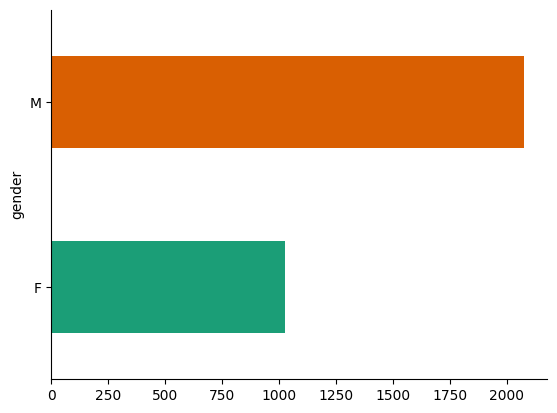

In [13]:
# @title gender

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('gender').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

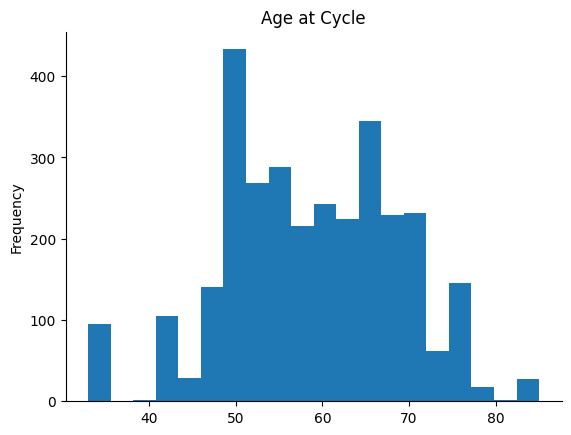

In [14]:
df['serving_age'].plot(kind='hist', bins=20, title='Age at Cycle')
plt.gca().spines[['top', 'right',]].set_visible(False)

<Axes: >

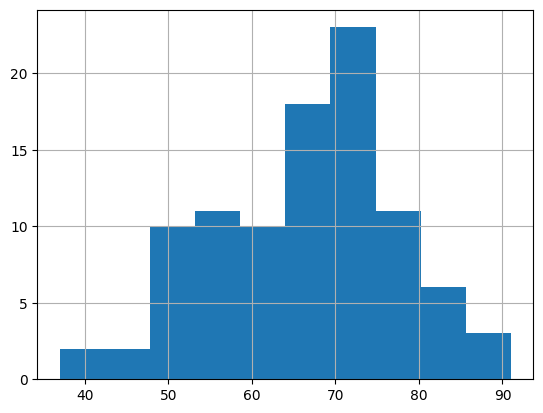

In [15]:
df.groupby('full_name')['age'].max().hist()

### TODO:
1) add the age at the time of serving -- done ✅

2) grab more features

<Axes: >

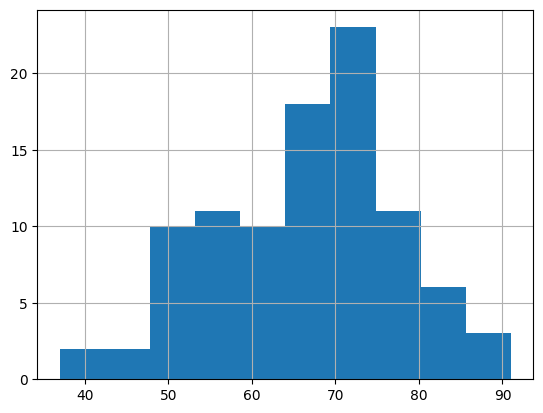

In [16]:
df.groupby('full_name')['age'].max().hist()

In [17]:
# todo: start_date & end_date -> How do we want to handle?

### Senator Photo Enrichment
3 - 20 Photos of senators at various events and points in time

### Emotion Detection
Classification and Valence scores

In [18]:
# generating random valence values as a placeholder
emotions = ['engagement','happiness','anticipation','excitement','confidence','pleasure','peace','disconnection','affection','esteem','sympathy']
df['top_emotion'] = np.random.choice(emotions, size=len(df))

df['valence'] = np.random.randint(0,10, size=len(df))

In [19]:
df['top_emotion'].value_counts()

disconnection    318
peace            295
pleasure         294
esteem           291
confidence       287
affection        283
happiness        280
anticipation     275
excitement       264
sympathy         258
engagement       257
Name: top_emotion, dtype: int64

<Axes: >

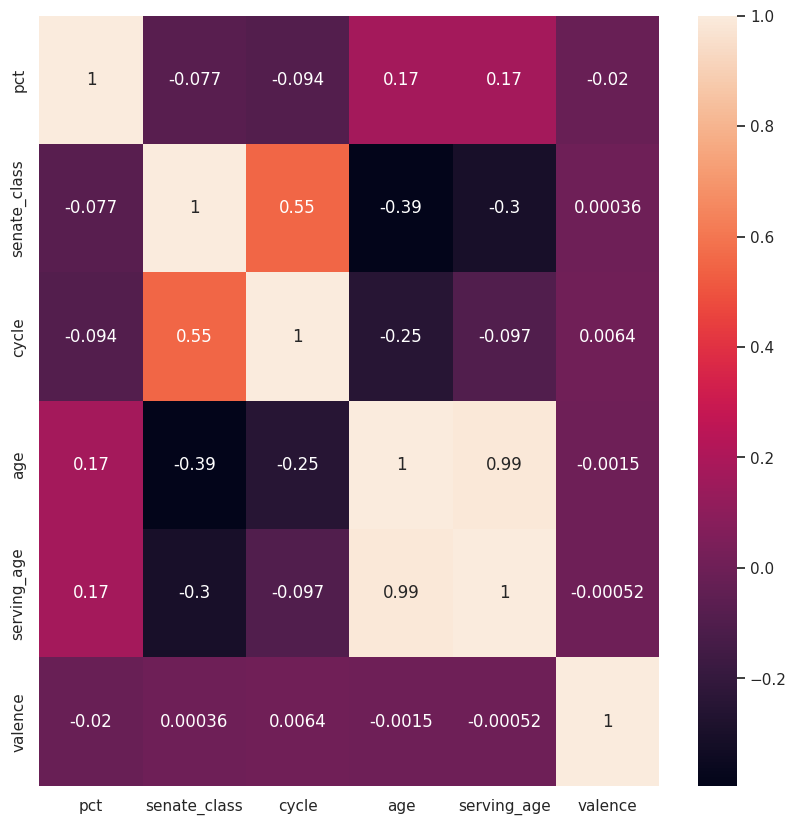

In [20]:
# create heatmap to view correlations
sns.set(font_scale = 1)
plt.figure(figsize = (10,10))
sns.heatmap(df.corr(), annot=True)

In [21]:
# todo: update with real inferences

In [22]:
df.head()

,full_name,pct,birthday,gender,party,senate_class,stage,cycle,start_date,end_date,age,serving_age,top_emotion,valence
0,Raphael G. Warnock,51.1,1969-07-23,M,Democrat,3.0,runoff,2022,2022-12-03,2022-12-05,55,53,esteem,3
1,Raphael G. Warnock,51.0,1969-07-23,M,Democrat,3.0,runoff,2022,2022-12-01,2022-12-05,55,53,disconnection,0
2,Raphael G. Warnock,50.5,1969-07-23,M,Democrat,3.0,runoff,2022,2022-12-04,2022-12-04,55,53,sympathy,6
3,Raphael G. Warnock,50.0,1969-07-23,M,Democrat,3.0,runoff,2022,2022-12-04,2022-12-04,55,53,esteem,9
4,Raphael G. Warnock,52.2,1969-07-23,M,Democrat,3.0,runoff,2022,2022-12-04,2022-12-04,55,53,affection,8


### Train/Test Split

In [23]:
# todo: random vs. stratified sampling for train/test split based on Senator?

In [24]:
df.head()

,full_name,pct,birthday,gender,party,senate_class,stage,cycle,start_date,end_date,age,serving_age,top_emotion,valence
0,Raphael G. Warnock,51.1,1969-07-23,M,Democrat,3.0,runoff,2022,2022-12-03,2022-12-05,55,53,esteem,3
1,Raphael G. Warnock,51.0,1969-07-23,M,Democrat,3.0,runoff,2022,2022-12-01,2022-12-05,55,53,disconnection,0
2,Raphael G. Warnock,50.5,1969-07-23,M,Democrat,3.0,runoff,2022,2022-12-04,2022-12-04,55,53,sympathy,6
3,Raphael G. Warnock,50.0,1969-07-23,M,Democrat,3.0,runoff,2022,2022-12-04,2022-12-04,55,53,esteem,9
4,Raphael G. Warnock,52.2,1969-07-23,M,Democrat,3.0,runoff,2022,2022-12-04,2022-12-04,55,53,affection,8


In [25]:
y = df.pop('pct')
y.shape

(3102,)

In [26]:
df.pop('full_name')

0       Raphael G. Warnock
1       Raphael G. Warnock
2       Raphael G. Warnock
3       Raphael G. Warnock
4       Raphael G. Warnock
               ...        
3097    Benjamin L. Cardin
3098    Benjamin L. Cardin
3099      Thomas R. Carper
3100      Thomas R. Carper
3101      Thomas R. Carper
Name: full_name, Length: 3102, dtype: object

In [27]:
df = df.drop(['birthday','start_date','end_date'],axis=1)

In [28]:
#using random shuffle
X_train, X_test, y_train, y_test = train_test_split(df,y, test_size=0.2, random_state=42)

In [29]:
#X_train = train[]
#y_train = train[]
#X_test = test[]
#y_test = test[]

## Feature Processing

### Final Feature Selection

In [47]:
target = ['pct'] # could we do binary classification with positive or negative score? --> are there negative scores in this column or scale 0 to 100
date_features = ['start_date','end_date'] # is cycle really "date" or categorical?
categorical_features = ['top_emotion','gender','party','senate_class','stage']
numeric_features = ['age','serving_age','valence']
word_features = ['full_name']

In [48]:
df.head()


,gender,party,senate_class,stage,cycle,age,serving_age,top_emotion,valence
0,M,Democrat,3.00,runoff,2022,55,53,esteem,3
1,M,Democrat,3.00,runoff,2022,55,53,disconnection,0
2,M,Democrat,3.00,runoff,2022,55,53,sympathy,6
3,M,Democrat,3.00,runoff,2022,55,53,esteem,9
4,M,Democrat,3.00,runoff,2022,55,53,affection,8


In [32]:
#check for dups
#df.drop_duplicates(inplace=True)


In [33]:
df.shape

(3102, 9)

In [34]:
df.isnull().sum()

gender          0
party           0
senate_class    0
stage           0
cycle           0
age             0
serving_age     0
top_emotion     0
valence         0
dtype: int64

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3102 entries, 0 to 3101
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   gender        3102 non-null   object 
 1   party         3102 non-null   object 
 2   senate_class  3102 non-null   float64
 3   stage         3102 non-null   object 
 4   cycle         3102 non-null   int64  
 5   age           3102 non-null   int64  
 6   serving_age   3102 non-null   int64  
 7   top_emotion   3102 non-null   object 
 8   valence       3102 non-null   int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 218.2+ KB


## update datatypes

In [36]:
for col in ['top_emotion','gender','party','senate_class','stage']:
  df[col] = df[col].astype('category')


### Normalize Numeric Features

In [49]:
# separate pipeline for numeric so more flexible with real data
num_pipe = Pipeline([
  ('std_scaler', StandardScaler())
])

### Encode Categorical Features

### Feat Pipeline

In [38]:
from sklearn import set_config

In [50]:
ctprocessor = ColumnTransformer(
  transformers=[
  ('numerical', StandardScaler(),numeric_features ),
  ('cat', OneHotEncoder(handle_unknown="ignore"),categorical_features),
  ],
  remainder='passthrough'
)

In [51]:
#display
set_config(display='diagram')
display(ctprocessor)

ColumnTransformer(remainder='passthrough',
                  transformers=[('numerical', StandardScaler(),
                                 ['age', 'serving_age', 'valence']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['top_emotion', 'gender', 'party',
                                  'senate_class', 'stage'])])

## Model Selection

### helper functions

In [85]:
## helper function for ensembling models
# evaluate a give model using cross-validation
def evaluate_model(model, X_train, y_train):
    cv = KFold(n_splits=4)
    pipeline = Pipeline(steps=[('preprocessor', ctprocessor), ('model',model)])

    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='r2')

    return scores

### Supervised Modeling

In [42]:
pip install lazypredict

In [43]:
import lazypredict
from lazypredict.Supervised import LazyRegressor

In [52]:
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)

In [53]:
ctprocessor.set_output(transform='default')


ColumnTransformer(remainder='passthrough',
                  transformers=[('numerical', StandardScaler(),
                                 ['age', 'serving_age', 'valence']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['top_emotion', 'gender', 'party',
                                  'senate_class', 'stage'])])

In [54]:
xtrain = ctprocessor.fit_transform(X_train)
xtest = ctprocessor.fit(X_test)

In [ ]:
type(xtrain)

In [56]:
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

'tuple' object has no attribute '__name__'
Invalid Regressor(s)


 76%|███████▌  | 32/42 [00:11<00:02,  3.84it/s]

QuantileRegressor model failed to execute
Solver interior-point is not anymore available in SciPy >= 1.11.0.


100%|██████████| 42/42 [00:14<00:00,  2.97it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 134
[LightGBM] [Info] Number of data points in the train set: 2481, number of used features: 24
[LightGBM] [Info] Start training from score 45.924925


In [59]:
print(models)

                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
RandomForestRegressor                        0.65       0.65  4.54        0.97
HistGradientBoostingRegressor                0.63       0.64  4.65        2.22
LGBMRegressor                                0.63       0.64  4.67        0.09
BaggingRegressor                             0.62       0.63  4.70        0.12
XGBRegressor                                 0.62       0.63  4.73        0.17
GradientBoostingRegressor                    0.62       0.62  4.75        0.33
MLPRegressor                                 0.57       0.57  5.04        2.66
KNeighborsRegressor                          0.56       0.57  5.07        0.04
ExtraTreesRegressor                          0.55       0.56  5.15        0.92
ExtraTreeRegressor                           0.49       0.49  5.50        0.05
DecisionTreeRegressor                        0.47   

### Linear Regression

In [60]:
lr = LinearRegression()

In [61]:
pipeline = Pipeline(steps=[('preprocessor', ctprocessor), ('model',lr)])

In [62]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical', StandardScaler(),
                                                  ['age', 'serving_age',
                                                   'valence']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['top_emotion', 'gender',
                                                   'party', 'senate_class',
                                                   'stage'])])),
                ('model', LinearRegression())])

In [66]:
from numpy import mean
from numpy import std

In [86]:
scores = evaluate_model(lr,X_train,y_train)
print('cross-validation score for %s -->  %.3f (std %.3f)' % ('linear Reg Model', mean(scores), std(scores)))

cross-validation score for linear Reg Model -->  0.424 (std 0.072)


cross-validation score for linear Reg Model -->  0.424 (std 0.072)


### Tree Methods
Decision Tree (and Random Forest for ensembles week)

AKA don't need encoded categorical features

In [ ]:
regressor = DecisionTreeRegressor(random_state=0)
cross_val_score(regressor, X, y, cv=10)

In [77]:
# f forest
rf = RandomForestRegressor(random_state=42)

In [79]:
scores = evaluate_model(rf,X_train,y_train)
print('cross-validation score for %s -->  %.3f (std %.3f)' % ('RandomForestRegressor Model', mean(scores), std(scores)))

cross-validation score for KNeighborsRegressor Model -->  0.580 (std 0.062)


### Other Methods
KNN

Requires Encoding

In [75]:
neigh = KNeighborsRegressor(n_neighbors=2)
#neigh.fit(X, y)

#print(neigh.predict([[1.5]]))

In [76]:
scores = evaluate_model(neigh,X_train,y_train)
print('cross-validation score for %s -->  %.3f (std %.3f)' % ('KNeighborsRegressor Model', mean(scores), std(scores)))

cross-validation score for KNeighborsRegressor Model -->  0.395 (std 0.051)


## Unsupervised Modeling

### KMeans and Hierarchical Clustering

In [ ]:
X = np.array([[1, 2], [1, 4], [1, 0], [10, 2], [10, 4], [10, 0]])
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(X)
kmeans.labels_
kmeans.predict([[0, 0], [12, 3]])
kmeans.cluster_centers_

In [ ]:
X = np.array([[1, 2], [1, 4], [1, 0], [4, 2], [4, 4], [4, 0]])
clustering = AgglomerativeClustering().fit(X)
clustering.labels_